## Imports

In [8]:
from support import load_dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
from tqdm.notebook import tqdm 

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

print("Python version:", os.sys.version)
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.7.0+cu118
CUDA available: True


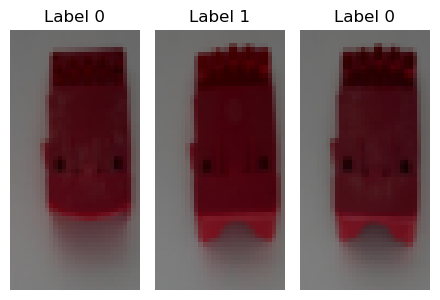

In [2]:
data = load_dataset()
train_dataset = data[0]
test_dataset = data[1]

transform_to_pil = T.ToPILImage()

# Find an image with label 0 in the test dataset
img0_tensor, label0 = train_dataset[0]
img0_pil = transform_to_pil(img0_tensor)

img02_tensor, label02 = train_dataset[20]
img02_pil = transform_to_pil(img02_tensor)

img1_tensor, label1 = train_dataset[70]
img1_pil = transform_to_pil(img1_tensor)

# Show both images side by side
fig, axs = plt.subplots(1, 3, figsize=(4.5, 3))
axs[0].imshow(img0_pil)
axs[0].set_title(f"Label {label0}")
axs[0].axis("off")
axs[1].imshow(img1_pil)
axs[1].set_title(f"Label {label1}")
axs[1].axis("off")
axs[2].imshow(img02_pil)
axs[2].set_title(f"Label {label02}")
axs[2].axis("off")
plt.tight_layout()
plt.show()

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # Keep resolution
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Downsample by 2
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Assuming input is 30x60, after 2 poolings: 7x15
        self.fc1 = nn.Linear(64 * 7 * 15, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))      # 30x60
        x = F.relu(self.conv2(x))      # 30x60
        x = self.pool(x)               # 15x30
        x = F.relu(self.conv3(x))      # 15x30
        x = self.pool(x)               # 7x15
        x = F.relu(self.conv4(x))      # 7x15
        x = x.view(-1, 64 * 7 * 15)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                # Output layer
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=6720, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [19]:
# Prepare DataLoader
batch_size = 16
learning_rate = 0.004
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss for binary classification

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        labels = labels.float().unsqueeze(1)  # Convert labels to float for BCEWithLogitsLoss
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Save the model
model_path = "tijn_cnn_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Epoch 1/5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1, Loss: 0.6937


Epoch 2/5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2, Loss: 0.6937


Epoch 3/5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3, Loss: 0.6934


Epoch 4/5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4, Loss: 0.6933


Epoch 5/5:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5, Loss: 0.6933


Best loss for learning rate = 0.001 -> Loss: 0.6941